In [1]:
library(ape)
library(jsonlite)
library(pheatmap)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
# library(viridis)
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(Biostrings))

dataDir <- "Data"
genomeTreeDir <- "Genome_tree"
snpDir <- "SNPs"
snpCompareDir <- "SNPs_comparison"
figureDir <- "Figures"
webImagesDir <- file.path("docs", "images")

locGroup <- list(
    "Hubei" = "Wuhan, China",
    "Guangdong" = "Guangdong, China",
    "USA" = "USA",
    "Japan" = "Japan",
    "Australia" = "Australia"
)

gpColors <- list(
    "G1" = "#EB261F",
    "G2" = "#1CA4FC",
    "G2.1" = "#00FFFF"
)

ntColors <- list(
    "A" = "#64F73F",
    "C" = "#FFB340",
    "G" = "#7E1272",
    "T" = "#FF00FF"
)

Warning message:
"package 'jsonlite' was built under R version 3.6.2"
Warning message:
"package 'pheatmap' was built under R version 3.6.2"
Warning message:
"package 'reshape2' was built under R version 3.6.2"
Warning message:
"package 'S4Vectors' was built under R version 3.6.2"
Warning message:
"package 'IRanges' was built under R version 3.6.2"


In [2]:
dir.create(figureDir, showWarnings = FALSE)

In [3]:
tree <- read.tree(file.path(genomeTreeDir, "RAxML_bestTree.GTRGAMMA"))
info <- read.csv(file.path(dataDir, "info.csv"))
allSNP <- read.csv(file.path(snpDir, "all.csv"))
genotypes <- read_json(file.path(dataDir, "genotypes.json"))
subGenotypes <- read_json(file.path(dataDir, "sub_genotypes.json"), simplifyVector = TRUE)

In [4]:
writeLines(as.character(unique(allSNP[["Pos"]])), file.path(snpDir, "loci.txt"))

In [5]:
length(tree$tip.label)

[1] 129

In [6]:
info <- info[complete.cases(info), ]

root2tipDist <- data.frame(
    "Dist" = node.depth.edgelength(tree)[1:length(tree$tip.label)],
    "Accession.ID" = tree$tip.label
)

info <- merge(info, root2tipDist, by = "Accession.ID")

In [7]:
info[["Genotype"]] <- NULL

for (gp in names(genotypes)) {
    for (id in genotypes[[gp]]) {
        info[which(info$Accession.ID == id), "Genotype"] <- gp
    }
}

In [8]:
info[["LocGroup"]] <- "Others"
locGroupLV <- character(0)

for (loc in names(locGroup)) {
    grp <- locGroup[[loc]]
    info[which(info[["Area"]] == loc), "LocGroup"] <- grp
    locGroupLV <- c(locGroupLV, grp)
}
locGroupLV <- c(locGroupLV, "Others")

info[["LocGroup"]] <- as.factor(info[["LocGroup"]])
info[["LocGroup"]] <- factor(info[["LocGroup"]], levels = locGroupLV)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



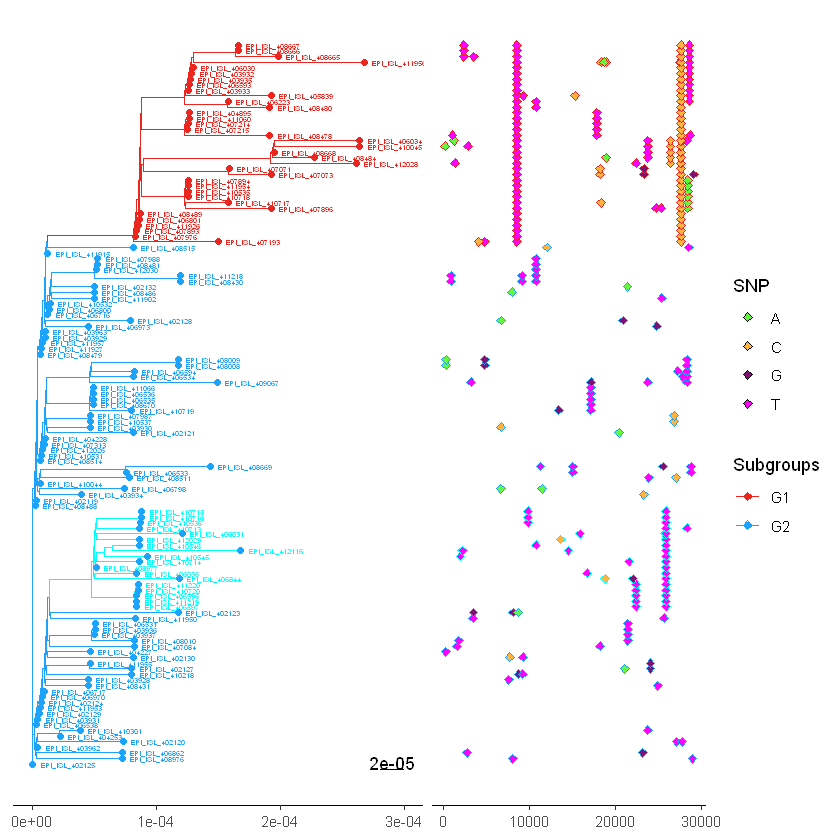

In [9]:
tree <- groupOTU(tree, subGenotypes, "Subgroups")

p <- ggtree(tree, aes(color=Subgroups))
p <- p %<+% info + 
    geom_tiplab(size = 1.5, hjust = -0.1) + 
    geom_tippoint(aes(color=Genotype)) +
    geom_treescale(x=0.00028, y=0, offset=0)

snp_data <- allSNP[, c("Accession.ID", "Pos", "SNP")]
p <- p + geom_facet(
    panel = "SNP",
    data = snp_data,
    geom = geom_point,
    mapping=aes(x = Pos, fill=SNP),
    shape = 23,
    size = 2,
    stroke = 0.01
) +
theme_tree2(
    strip.background = element_blank(),
    strip.text.x = element_blank(),
#     axis.text.x = element_text(angle = 90, vjust = 0.5, size = 3)
) +
scale_color_manual(values = gpColors, limits = names(genotypes)) +
scale_fill_manual(values = ntColors)
# scale_x_continuous(snp_data$Pos, labels = snp_data$Pos, breaks = snp_data$Pos)
p <- facet_widths(p, widths = c(1.5, 1))

print(p)

ggsave(filename = file.path(figureDir, "figure1.pdf"), plot = p, device = "pdf")
ggsave(filename = file.path(webImagesDir, "tree_and_snps.svg"), plot = p, device = "svg")

Saving 6.67 x 15 in image



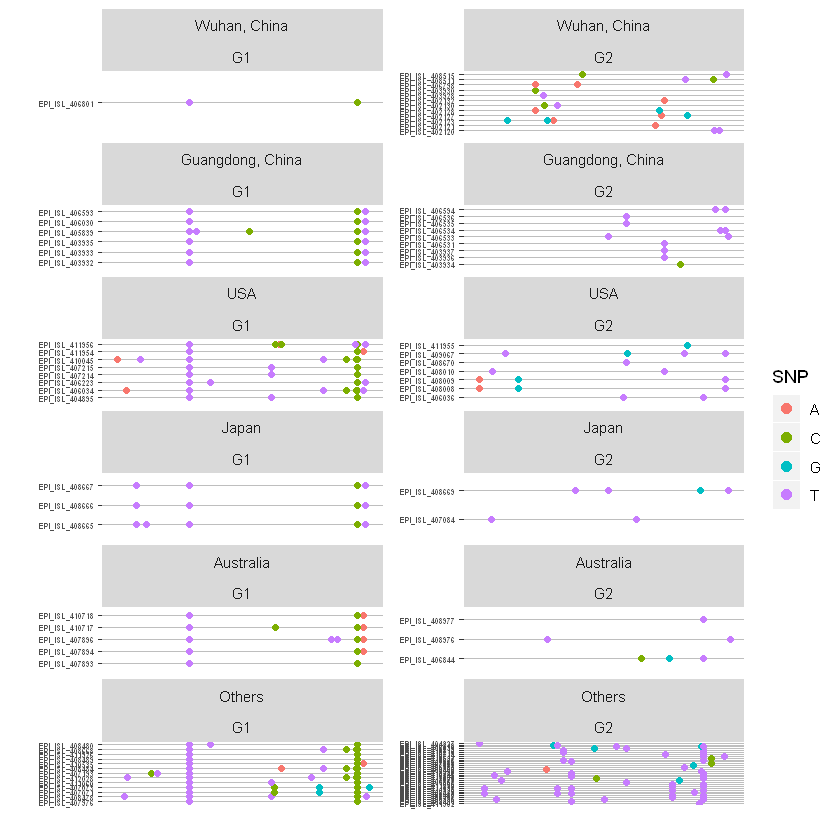

In [10]:
snp <- allSNP[, c("Accession.ID", "Pos", "SNP", "Product")]
snp <- merge(snp, info, by = "Accession.ID", all.x = TRUE)
snp["isHubei"] <- factor(c("non-Hubei", "Hubei")[(as.character(snp$Area) == "Hubei") + 1])
# levels(snp$Accession.ID) <- as.character(snp$Accession.ID[order(snp$Area)])
snp$Area_ID <- as.integer(snp$Area)

p <- ggplot(snp, aes(x = reorder(Accession.ID, Area_ID), y = Pos, fill = SNP, color = SNP)) +
    geom_dotplot(binaxis = "y", binwidth = 1, dotsize = 750, stackdir='center') +
#     xlim(seq_len(0, 21399)) +
    coord_flip() +
    ylim(0, 29133) +
    ylab("") + xlab("") +
    facet_wrap(~ LocGroup + Genotype, nrow = length(unique(snp$LocGroup)), scales = "free_y") +
#     facet_grid(LocGroup ~ Genotype, scales = "free_y", space = "free") +
    theme(
        panel.grid.major = element_line(colour="grey", size = 0.1), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.background = element_rect(fill = NA),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.text.y=element_text(size=5, face="bold")
    )
print(p)

ggsave(filename = file.path(figureDir, "figure2b.pdf"), plot = p, height = 15, device = "pdf")

Saving 6.67 x 9 in image



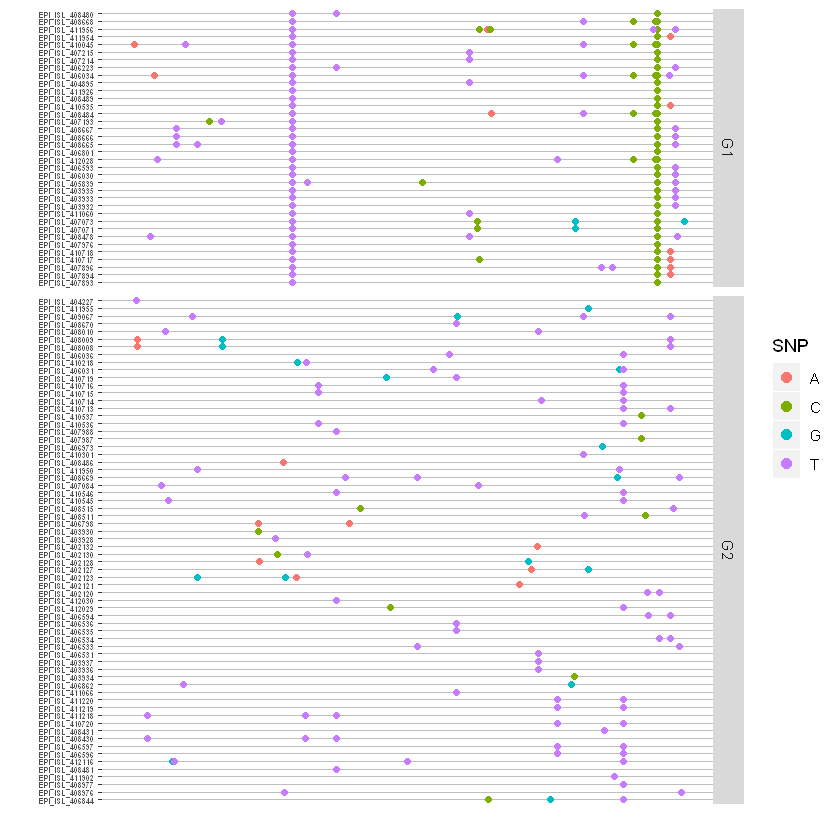

In [11]:
p <- ggplot(snp, aes(x = reorder(Accession.ID, Area_ID), y = Pos, fill = SNP, color = SNP)) +
    geom_dotplot(binaxis = "y", binwidth = 1, dotsize = 350, stackdir='center') +
#     xlim(seq_len(0, 21399)) +
    coord_flip() +
    ylim(0, 29133) +
    ylab("") + xlab("") +
    facet_grid(Genotype ~ ., scales = "free_y", space = "free") +
    theme(panel.grid.major = element_line(colour="grey", size = 0.1), 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.background = element_rect(fill = NA),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.text.y=element_text(size=5, face="bold"))
print(p)

ggsave(filename = file.path(figureDir, "figure2a.pdf"), plot = p, height = 9)

In [12]:
forlabeling <- unique(snp[, c("Accession.ID", "Area", "Genotype")])
forlabeling <- lapply(split(forlabeling, forlabeling$Genotype), function(i) {
    res <- i[order(i[["Area"]]), ]
    res
})
for (gp in names(forlabeling)) {
    write.csv(forlabeling[[gp]], file.path(snpDir, paste0(gp, "SNParea.csv")))
}

In [13]:
allSNPsum <- table(allSNP[, c("Pos", "SNP")])
allSNPsum <- apply(allSNPsum, 1, function(i) {
    sum(i)
})

allSNPsum <- as.integer(names(allSNPsum[allSNPsum != 1]))
allSNP <- allSNP[allSNP[, "Pos"] %in% allSNPsum, ]

In [14]:
seqs <- readDNAMultipleAlignment(file.path(genomeTreeDir, "aligned_cds.fasta"))
seqs <- as.character(seqs)

aaMut <- as.data.frame(t(apply(allSNP, 1, function(row) {
    accession <- row[["Accession.ID"]]
    pos <- as.integer(row[["Pos"]])
    shift <- pos %% 3
    if (shift == 0) {
        codon <- substr(seqs[[accession]], pos - 2, pos)
        refCodon <- paste0(substr(codon, 1, 2), row[["Ref"]])
    } else if (shift == 1) {
        codon <- substr(seqs[[accession]], pos, pos + 2)
        refCodon <- paste0(row[["Ref"]], substr(codon, 2, 3))
    } else {
        codon <- substr(seqs[[accession]], pos - 1, pos + 1)
        refCodon <- paste0(substr(codon, 1, 1), row[["Ref"]], substr(codon, 3, 3))
    }
    
    aa <- GENETIC_CODE[[codon]]
    refAA <- GENETIC_CODE[[refCodon]]
    
    aaPos <- ceiling(pos / 3)
    
    c(row[["Accession.ID"]], aa, refAA, pos, aaPos, row[["Product"]], row[["Product.ID"]])
})), stringsAsFactors = FALSE)

colnames(aaMut) <- c("Accession.ID", "mutAA", "refAA", "ntPos", "aaPos", "Product", "Product.ID")
write.csv(aaMut, file.path(snpDir, "amino_acid_substitutions.csv"), row.names = FALSE)
aaMut <- aaMut[
    which(aaMut$mutAA != aaMut$refAA),
    c("Accession.ID", "mutAA", "refAA", "ntPos", "aaPos", "Product", "Product.ID")
]

In [15]:
original <- read.csv(file.path(dataDir, "original.csv"),stringsAsFactors = FALSE)

In [16]:
ancestralName <- "EPI_ISL_402125 (reference)"

In [17]:
seqsAnimal <- as.character(readDNAMultipleAlignment(file.path(snpCompareDir, "aligned_cds.fasta")))
ref2aligned <- read_json(file.path(snpCompareDir, "ref2aligned_cds.json"))

seqsAnimal <- seqsAnimal[original[
    original[["Host"]] == "Manis javanica" | original[["Host"]] == "Rhinolophus affinis",
    "Accession.ID"
]]

seqsAnimal <- seqsAnimal[!is.na(seqsAnimal)]

animalMeta <- original[original[["Accession.ID"]] %in% names(seqsAnimal), ]
animalMeta <- animalMeta[order(animalMeta[["Host"]]),]

In [18]:
nonDupNTpos <- !duplicated(aaMut[["ntPos"]])
nonDupNT <- aaMut[nonDupNTpos, "ntPos"]
names(nonDupNT) <- aaMut[nonDupNTpos, "aaPos"]
ntPos <- ref2aligned[nonDupNT]
names(ntPos) <- aaMut[nonDupNTpos, "aaPos"]

mutCodonPos <- lapply(names(ntPos), function(refPos) {
    pos <- ntPos[[refPos]]
    shift <- as.integer(nonDupNT[[refPos]]) %% 3
    if (shift == 0) {
        codons <- substr(seqsAnimal, pos - 2, pos)
    } else if (shift == 1) {
        codons <- substr(seqsAnimal, pos, pos + 2)
    } else {
        codons <- substr(seqsAnimal, pos - 1, pos + 1)
    }
    aa <- sapply(codons, function(codon) {
        if (codon == "TTN") {
            codon <- "TTG"
        } else if (codon == "---") {
            return('-')
        } else if (codon == "CST") {
            codon <- "CGT"
        } else if (codon == "TTY") {
            codon <- "TTT"
        }
        return(GENETIC_CODE[[codon]])
    })
    return(aa)
})
names(mutCodonPos) <- names(ntPos)

In [19]:
# animalMeta <- rbind(
#     original[original[["Host"]] == "Rhinolophus affinis",],
#     original[original[["Host"]] == "Manis javanica" &
#              !original[["Accession.ID"]] %in% c("EPI_ISL_410543", "EPI_ISL_410544"), ]
# )

In [20]:
# rn <- c(
#     original[original[["Host"]] == "Rhinolophus affinis", "Accession.ID"],
#     original[original[["Host"]] == "Manis javanica" &
#              !original[["Accession.ID"]] %in% c("EPI_ISL_410543", "EPI_ISL_410544"), "Accession.ID"]
# )

rn <- animalMeta[["Accession.ID"]]

animalAA <- data.frame(row.names = rn)
mutCodonPos <- lapply(names(mutCodonPos), function(pos) {
    i <- mutCodonPos[[pos]]
    res <- as.data.frame(i[row.names(animalAA)])
    names(res) <- pos
    return(res)
})

In [21]:
animalAA <- do.call(cbind, mutCodonPos)

In [22]:
aaSubNames <- dcast(aaMut[, c("Accession.ID", "aaPos", "mutAA")], Accession.ID ~ aaPos, value.var = "mutAA")
aaSubNames[is.na(aaSubNames)] <- "."
row.names(aaSubNames) <- aaSubNames$Accession.ID
aaSubNames <- aaSubNames[, -1]
aaSubNames <- aaSubNames[, order(as.integer(colnames(aaSubNames)))]

locationInfo <- info[which(info[["Accession.ID"]] %in% row.names(aaSubNames)), c("Accession.ID", "LocGroup")]
orderedAC <- as.character(locationInfo[order(locationInfo[["LocGroup"]]), "Accession.ID"])
aaSubNames <- aaSubNames[orderedAC, ]

ancAAnames <- data.frame(t(unique(aaMut[, c("aaPos", "refAA")])[["refAA"]]))
colnames(ancAAnames) <- colnames(aaSubNames)
rownames(ancAAnames) <- ancestralName
aaSubMatNames <- rbind(ancAAnames, aaSubNames)

# for (i in seq_len(ncol(aaSubMatNames))) {
#     aaSubMatNames[is.na(aaSubMatNames[, i]), i] <- aaSubMatNames["Ancestral", i]
# }

In [23]:
animalAAnames <- as.data.frame(t(apply(animalAA, 1, function(i) {
    res <- rep(".", length(i))
    nonMut <- which(i != ancAAnames)
    res[nonMut] <- i[nonMut]
    res
})))
colnames(animalAAnames) <- colnames(animalAA)

In [24]:
gp1aaNames <- aaSubMatNames[row.names(aaSubMatNames) %in% genotypes[["G1"]], ]
gp1aaNames <- rbind(ancAAnames, animalAAnames, gp1aaNames)

gp2aaNames <- aaSubMatNames[row.names(aaSubMatNames) %in% genotypes[["G2"]], ]
# gp2aaNames <- rbind(ancAAnames, gp2aaNames)

In [25]:
aaSub <- aaMut
aaSub <- merge(aaSub, info, by = "Accession.ID", all.x = TRUE)

aaSub[["Mutated"]] <- 2 # Value of mutation in heatmap

aaSub <- dcast(aaSub[, c("Accession.ID", "aaPos", "Mutated")], Accession.ID ~ aaPos, value.var = "Mutated")
aaSub[is.na(aaSub)] <- 0
row.names(aaSub) <- aaSub$Accession.ID
aaSub <- aaSub[, -1]
aaSub <- aaSub[, order(as.integer(colnames(aaSub)))]

aaSub <- aaSub[orderedAC, ]

ancAA <- data.frame(t(rep(1, ncol(aaSub))))
colnames(ancAA) <- colnames(aaSub)
rownames(ancAA) <- ancestralName
aaSubMat <- rbind(ancAA, aaSub)

In [26]:
animalAAmat <- as.data.frame(t(apply(animalAA, 1, function(i) {
    res <- rep(0, length(i))
    nonMut <- which(i != ancAAnames)
    res[nonMut] <- 2
    res
})))
colnames(animalAAmat) <- colnames(animalAA)

In [27]:
gp1aa <- aaSubMat[row.names(aaSubMat) %in% genotypes[["G1"]], ]
gp1aa <- rbind(ancAA, animalAAmat, gp1aa)

gp2aa <- aaSubMat[row.names(aaSubMat) %in% genotypes[["G2"]], ]
# gp2aa <- rbind(ancAA, gp2aa)

In [28]:
domain <- as.data.frame(unique(aaMut[,c("aaPos", "Product", "Product.ID")]))
productID <- as.factor(domain$Product)
domain[["Product"]] <- factor(productID, levels = unique(domain[["Product"]]))
domain <- data.frame(domain[order(as.integer(domain[["aaPos"]])), ])
rn <- domain[["aaPos"]]
domain <- data.frame("Product" = domain[["Product"]])
row.names(domain) <- rn

In [29]:
strainAnno <- info[, c("Accession.ID", "Genotype", "LocGroup")]
strainsLoc <- as.data.frame(unique(strainAnno[, c("Accession.ID", "Genotype", "LocGroup")]))
colnames(strainsLoc)[3] <- "Location"
row.names(strainsLoc) <- strainsLoc[["Accession.ID"]]
strainsLoc <- strainsLoc[,c(3, 2)]

In [30]:
animalInfo <- animalMeta[, c("Accession.ID", "Location", "Host")]

animalInfo[["Location"]] <- "Wild animals"

row.names(animalInfo) <- animalInfo[["Accession.ID"]]
colnames(animalInfo)[3] <- "Genotype"
animalInfo <- animalInfo[, -1]

In [31]:
strainsLoc <- rbind(strainsLoc, animalInfo)

In [32]:
colors <- list(
    "Product" = rev(brewer.pal(length(unique(domain[["Product"]])), "Set1")),
    "Location" = colorRampPalette(brewer.pal(3, "Set3"))(length(unique(strainsLoc[["Location"]]))),
    "Genotype" = c("#000000", "#808080", "#EB261F", "#1CA4FC")
)

names(colors[["Product"]]) <- unique(domain[["Product"]])
names(colors[["Location"]]) <- unique(strainsLoc[["Location"]])
names(colors[["Genotype"]]) <- rev(unique(strainsLoc[["Genotype"]]))

png 
  2

png 
  2

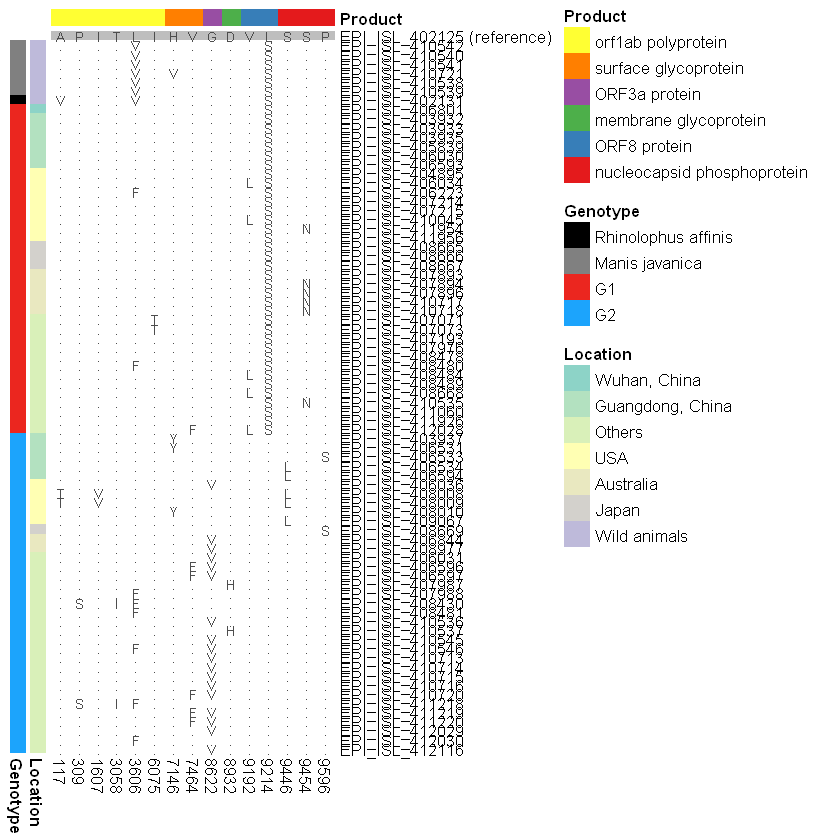

In [33]:
combinedMat <- rbind(gp1aa, gp2aa[-1,])
combinedMatNames <- rbind(gp1aaNames, gp2aaNames[-1,])

p <- pheatmap(
    mat = combinedMat,
    color = colorRampPalette(c("white", "grey", "white"))(3),
    border_color = NA,
    show_colnames = TRUE,
    show_rownames = TRUE,
    cluster_cols = FALSE,
    cluster_rows = FALSE,
    annotation_col = domain,
    annotation_colors = colors,
    annotation_row = strainsLoc,
    drop_levels = TRUE,
    display_numbers = combinedMatNames,
    legend = FALSE
)
pdf(file = file.path(figureDir, "figure3.pdf"), width=7, height=12)
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

svg(filename = file.path(webImagesDir, "amino_acids_substitutions.svg"), width=7, height=12)
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

In [34]:
# p <- pheatmap(
#     mat = gp1aa,
#     color = colorRampPalette(c("white", "grey", "white"))(3),
#     border_color = NA,
#     show_colnames = TRUE,
#     show_rownames = TRUE,
#     cluster_cols = FALSE,
#     cluster_rows = FALSE,
#     annotation_col = domain,
#     annotation_colors = colors,
#     annotation_row = strainsLoc,
#     drop_levels = TRUE,
#     display_numbers = gp1aaNames,
#     legend = FALSE,
# )
# pdf(file = file.path(figureDir, "figure3a.pdf"), width=7, height=5)
# grid::grid.newpage()
# grid::grid.draw(p$gtable)
# dev.off()

In [35]:
# p <- pheatmap(
#     mat = gp2aa,
#     color = colorRampPalette(c("white", "grey", "white"))(3),
#     border_color = NA,
#     show_colnames = TRUE,
#     show_rownames = TRUE,
#     cluster_cols = FALSE,
#     cluster_rows = FALSE,
#     annotation_col = domain,
#     annotation_colors = colors,
#     annotation_row = strainsLoc,
#     drop_levels = TRUE,
#     display_numbers = gp2aaNames,
#     legend = FALSE
# )
# pdf(file = file.path(figureDir, "figure3b.pdf"), width=7, height=5.5)
# grid::grid.newpage()
# grid::grid.draw(p$gtable)
# dev.off()

In [36]:
# p <- pheatmap(
#     mat = aaSubMat,
#     color = colorRampPalette(c("white", "grey", "white"))(3),
#     border_color = NA,
#     show_colnames = TRUE,
#     show_rownames = TRUE,
#     cluster_cols = FALSE,
#     cluster_rows = FALSE,
#     annotation_col = domain,
#     annotation_colors = colors,
#     annotation_row = strainsLoc,
#     drop_levels = TRUE,
#     display_numbers = aaSubMatNames,
#     legend = FALSE
# )
# pdf(file = file.path(figureDir, "figure3c.pdf"), width=7, height=12)
# grid::grid.newpage()
# grid::grid.draw(p$gtable)
# dev.off()